# BPDM In the Lab Tutorial - Fairness in Data Mining: Credit Example

__Tools:__ Analysis will be done in python, using a number of useful open source python packages:
- __Numpy__ Python's scientific computing package. http://www.numpy.org/
- __Pandas__ A very useful data analysis and manipulation package http://pandas.pydata.org/
- __Scikit-learn__ A comprehensive machine learning library http://scikit-learn.org/stable/
- __Matplotlib__ Package for creating charts and other visualizations https://matplotlib.org/

All these packages come bundled as part of the Anaconda python distribution. Install Anaconda for the simplest way to get all dependancies for the tutorial:
__Anaconda__ https://www.anaconda.com/download/


You can run the code in each cell below by clicking on the cell and using the run button in the toolbar above, or typing ctrl+enter 

In [68]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set(font_scale=1.5)
import itertools
from sklearn.metrics import roc_curve
from utilities import *
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')


## Material:
In this tutorial we will analyze the [Statlog German Credit dataset](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data) published by the UCI Machine learning library. We frame our problem as a supervised classification task -- predicting creditworthiness -- and invetigate whether any unfair bias may be impacting our analysis.

The tutorial proceeds with the following tasks:

**Step 1. Data Prep**

    - We first clean and preprocess the data: converting qualitative attributes to numeric, binarizing the target credit attribute, and identifying sensitive attributes which should not legally impact credit decsions.
    - Then we split the data into a 70% training data, 30% testing data.

**Step 2. Data Exploration**

    - We analyze the attributes in the training dataset to understand them better and assess whether there is a historical unfair bias present in the data.
    
**Step 3. Training**
    
    - We train a binary classifier to predict creditworthiness.
    
**Step 4. Evaluation**
    
    - We evaluate the fairness of our resulting predictions.

**Step 5. Discussion and Provocations**

    - What steps can we take to mitigate any observed unfairness in this data analysis pipeline?
    
Suggestions for further experimentation are given throughout in <font color=red>Red!</font>


# Step 1: Data prep

First we import the German Credit dataset and store it in a Pandas [dataframe](https://pandas.pydata.org/pandas-docs/version/0.21/generated/pandas.DataFrame.html) object.

Here is an explaination of the features in the dataset :

 
**Attribute 1:**  (qualitative) Status of existing checking account          
- A11 :      ... <    0 DM	       
- A12 : 0 <= ... <  200 DM	       
- A13 :      ... >= 200 DM / salary assignments for at least 1 year         
- A14 : no checking account

**Attribute 2:**  (numerical)  Duration in month

**Attribute 3:**  (qualitative) Credit history
- A30 : no credits taken/ all credits paid back duly
- A31 : all credits at this bank paid back duly
- A32 : existing credits paid back duly till now
- A33 : delay in paying off in the past
- A34 : critical account/other credits existing (not at this bank)

**Attribute 4:**  (qualitative) Purpose
- A40 : car (new)
- A41 : car (used)
- A42 : furniture/equipment
- A43 : radio/television
- A44 : domestic appliances
- A45 : repairs
- A46 : education
- A47 : (vacation - does not exist?)
- A48 : retraining
- A49 : business
- A410 : others

**Attribute 5:**  (numerical) Credit amount

**Attibute 6:**  (qualitative) Savings account/bonds
- A61 :          ... <  100 DM
- A62 :   100 <= ... <  500 DM
- A63 :   500 <= ... < 1000 DM
- A64 :          .. >= 1000 DM
- A65 :   unknown/ no savings account

**Attribute 7:**  (qualitative) Present employment since
- A71 : unemployed
- A72 :       ... < 1 year
- A73 : 1  <= ... < 4 years  
- A74 : 4  <= ... < 7 years
- A75 :       .. >= 7 years

**Attribute 8:**  (numerical) Installment rate in percentage of disposable income

**Attribute 9:**  (qualitative) Personal status and sex
- A91 : male   : divorced/separated
- A92 : female : divorced/separated/married
- A93 : male   : single
- A94 : male   : married/widowed
- A95 : female : single

**Attribute 10:** (qualitative) Other debtors / guarantors
- A101 : none
- A102 : co-applicant
- A103 : guarantor

**Attribute 11:** (numerical) Present residence since

**Attribute 12:** (qualitative) Property
- A121 : real estate
- A122 : if not A121 : building society savings agreement/life insurance
- A123 : if not A121/A122 : car or other, not in attribute 6
- A124 : unknown / no property

**Attribute 13:** (numerical)
	      Age in years

**Attribute 14:** (qualitative) Other installment plans 
- A141 : bank
- A142 : stores
- A143 : none

**Attribute 15:** (qualitative) Housing
- A151 : rent
- A152 : own
- A153 : for free

**Attribute 16:** (numerical) Number of existing credits at this bank

**Attribute 17:** (qualitative) Job
- A171 : unemployed/ unskilled  - non-resident
- A172 : unskilled - resident
- A173 : skilled employee / official
- A174 : management/ self-employed/highly qualified employee/ officer

**Attribute 18:** (numerical) Number of people being liable to provide maintenance for

**Attribute 19:** (qualitative) Telephone
- A191 : none
- A192 : yes, registered under the customers name

**Attribute 20:** (qualitative) foreign worker
- A201 : yes
- A202 : no

In [84]:
# German Credit dataset UCI Machine learning library:
# https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29
    


# df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data", 
#                     names=['checking_account','Duration_months','Credit_history','Purpose','Credit_amount',
#                            'savings_account','employment_years','Installment_rate','status_sex','Other_debtors',
#                            'Present residence','Property','Age','installment_plans','Housing','existing_credits',
#                            'Job','maintenance','Telephone','Foreign_worker'],index_col=False, sep=None,engine='python')
# df.to_pickle("german.pkl")

In [122]:
df = pd.read_pickle("german.pkl")

First, let's take a look at this dataset. We print the number of data instances, features, and then the first entries.

In [123]:
print("Number of data instances:", df.shape[0])
print("Number of data attributes:", df.shape[1])
print(list(df))
df.head()

Number of data instances: 1000
Number of data attributes: 20
['checking_account', 'Duration_months', 'Credit_history', 'Purpose', 'Credit_amount', 'savings_account', 'employment_years', 'Installment_rate', 'status_sex', 'Other_debtors', 'Present residence', 'Property', 'Age', 'installment_plans', 'Housing', 'existing_credits', 'Job', 'maintenance', 'Telephone', 'Foreign_worker']


,checking_account,Duration_months,Credit_history,Purpose,Credit_amount,savings_account,employment_years,Installment_rate,status_sex,Other_debtors,Present residence,Property,Age,installment_plans,Housing,existing_credits,Job,maintenance,Telephone,Foreign_worker
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201


Since we have many qualitative data attributes, we want to convert them to numeric attributes. We will use [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to represent them with binary attributes. This changes the number of attributes in our dataset.

<font color=red>You can experiment with different ways of transforming or encoding the data attributes, or using only a subset.</font>

Of particular interest here are **sensitive data attributes** of age and gender included in the dataset. It is illegal to discriminate when making loan decisions on the basis of age or gender. For now, in this analysis , we will drop the attribute 'status_sex' which conflates both gender and marital status, and set our protected attribute to be age. First we look at the range of ages in the dataset, and then threshold them into two groups: a disadvantaged group younger than 25, and a priviledged group 25 and above.

<font color=red>You can experiment with setting different thresholds, choosing to use a different protected attribute, or examine intersectional groups</font> 

In [124]:
# Drop gender and martial status from the dataset
df.drop('status_sex', axis=1, inplace=True)

# transform categorical attributes to numeric
df = pd.get_dummies(df, drop_first=True)
print("Number of attributes in transformed dataset:", df.shape[1])
print(list(df))
df.head()

Number of attributes in transformed dataset: 45
['Duration_months', 'Credit_amount', 'Installment_rate', 'Present residence', 'Age', 'existing_credits', 'maintenance', 'checking_account_A12', 'checking_account_A13', 'checking_account_A14', 'Credit_history_A31', 'Credit_history_A32', 'Credit_history_A33', 'Credit_history_A34', 'Purpose_A41', 'Purpose_A410', 'Purpose_A42', 'Purpose_A43', 'Purpose_A44', 'Purpose_A45', 'Purpose_A46', 'Purpose_A48', 'Purpose_A49', 'savings_account_A62', 'savings_account_A63', 'savings_account_A64', 'savings_account_A65', 'employment_years_A72', 'employment_years_A73', 'employment_years_A74', 'employment_years_A75', 'Other_debtors_A102', 'Other_debtors_A103', 'Property_A122', 'Property_A123', 'Property_A124', 'installment_plans_A142', 'installment_plans_A143', 'Housing_A152', 'Housing_A153', 'Job_A172', 'Job_A173', 'Job_A174', 'Telephone_A192', 'Foreign_worker_A202']


,Duration_months,Credit_amount,Installment_rate,Present residence,Age,existing_credits,maintenance,checking_account_A12,checking_account_A13,checking_account_A14,...,Property_A124,installment_plans_A142,installment_plans_A143,Housing_A152,Housing_A153,Job_A172,Job_A173,Job_A174,Telephone_A192,Foreign_worker_A202
0,6,1169,4,4,67,2,1,0,0,0,...,0,0,1,1,0,0,1,0,1,0
1,48,5951,2,2,22,1,1,1,0,0,...,0,0,1,1,0,0,1,0,0,0
2,12,2096,2,3,49,1,2,0,0,1,...,0,0,1,1,0,1,0,0,0,0
3,42,7882,2,4,45,1,2,0,0,0,...,0,0,1,0,1,0,1,0,0,0
4,24,4870,3,4,53,2,2,0,0,0,...,1,0,1,0,1,0,1,0,0,0


Let's look at the distribution of ages and then bin them into groups

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000042F109D978>]], dtype=object)

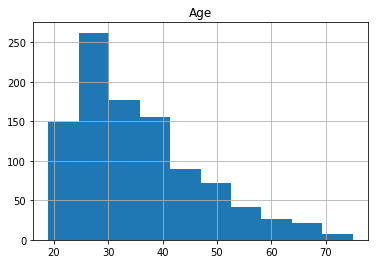

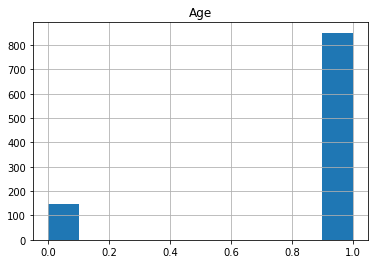

In [145]:
threshold=25

df.hist('Age')

# threshold
thresh_age = df.copy()
thresh_age.loc[thresh_age.Age<threshold, 'Age'] = 0.0
thresh_age.loc[thresh_age.Age>=threshold, 'Age'] = 1.0

thresh_age.hist('Age')

## Step 2: Data Exploration 

So far we can observe that the younger group is underrepresented in our dataset. Let's look at the relationship between other attributes, starting with the credit score distribution between youger and older people.

In [146]:
table = thresh_age.groupby(['Age'])['Credit_amount'].mean()
# .reset_index().pivot(index='Credit_amount',columns='Age',values=0)
# table = df.groupby(['race','decile_score']).size()

# percentage of defendants in each score category
# 100*table/table.sum()
# percentage of defendants in each score category
# 100*table/table.sum()
table

Age
0.0    2958.758389
1.0    3325.972973
Name: Credit_amount, dtype: float64

Text(0,0.5,'Fraction of population')

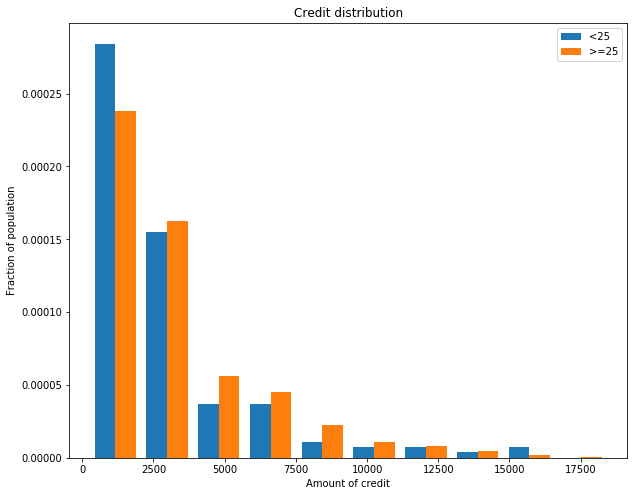

In [151]:
# now in visual form
x = thresh_age.loc[thresh_age['Age']==0.0, 'Credit_amount'].values
y = thresh_age.loc[thresh_age['Age']==1.0,'Credit_amount'].values
plt.figure(figsize=[10,8])
plt.hist([x,y], normed=True)
plt.legend(['<25','>=25'])
plt.title('Credit distribution')
plt.xlabel('Amount of credit')
plt.ylabel('Fraction of population')

We can also look for correlations between attributes

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000042F301F550>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000042F5022BA8>]], dtype=object)

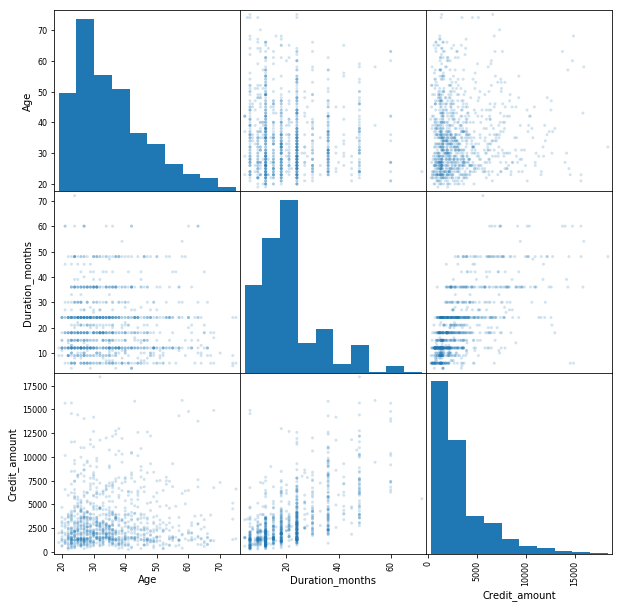

In [150]:
from pandas.plotting import scatter_matrix

scatter_matrix(df[['Age','Duration_months', 'Credit_amount']], alpha=0.2, figsize=(10,10))

The correlation is not that high. Let's measure the disparate impact of the quantized COMPAS score ($\leq4$ is low, everything else is high) according to the EEOC rule that the values with "high" for each protected group should be within 80% of each other. Of course, the interpertation here is not the same, but it's a good starting point.

reference: https://en.wikipedia.org/wiki/Disparate_impact#The_80.25_rule

In [16]:
# The correlation is not that high. Let's measure the disparate impact according to the EEOC rule
means = dfQ.groupby(['score_text','race']).size().unstack()
means = means/means.sum()
print(means)
# compute disparte impact
AA_with_high_score = means.loc[1,'African-American']
C_with_high_score = means.loc[1,'Caucasian']
percentage_diff = 100*(AA_with_high_score/C_with_high_score -1)
print('Percentage difference: %f%%' %percentage_diff)

race        African-American  Caucasian
score_text                             
0                   0.423937   0.669044
1                   0.576063   0.330956
Percentage difference: 74.060413%


The percentage of African-Americans who receive a higher score is 74% higher than Caucasians, so the COMPAS algorithm seems to have a disparate impact based on this rule. How does this change when we apply the same rule with with the true two year recidivism instead of the quantized COMPAS score?

In [17]:
means = dfQ.groupby(['two_year_recid','race']).size().unstack()
means = means/means.sum()
print(means)
# compute disparte impact
AA_with_high_score = means.loc[1,'African-American']
C_with_high_score = means.loc[1,'Caucasian']
percentage_diff = 100*(AA_with_high_score/C_with_high_score -1)
print(percentage_diff)

race            African-American  Caucasian
two_year_recid                             
0                        0.47685    0.60913
1                        0.52315    0.39087
33.8422897868


There is a difference in recidivism, but not as high as assigned by the COMPAS scores.

Now let's measure the difference in scores when we consider both the COMPAS output at true recidivism.

We will consider a few different metrics. Further explaination can be found in North Point's response to the ProPublica article, and also in Alexandra Chouldechova’s paper (listed above). The link for it is https://assets.documentcloud.org/documents/2998391/ProPublica-Commentary-Final-070616.pdf . The discussion on error rates and calibration also appear in both. 

We first look at a metric called *callibration*. For $Y$ indicating two year recidivism, $S_Q$ indicating score (0=low, 1=high medium), and $R$ indicating race, we measure
$$\mathsf{cal} \triangleq \frac{\mathbb{P}\left(Y=1\mid S_Q=s,R=\mbox{African-American} \right)}{\mathbb{P}\left(Y=1 \mid S_Q=s,R=\mbox{Caucasian} \right)},$$ for different scores $s$. Considering our quantized scores, we look at the calibration for $s=1$. 

In [18]:
# compute averages
dfAverage = dfQ.groupby(['race','score_text'])['two_year_recid'].mean().unstack()
print(dfAverage)

num = dfAverage.loc['African-American',1]
denom = dfAverage.loc['Caucasian',1]
cal = num/denom
calpercent = 100*(cal-1)
print('Calibration: %f' % cal)
print('Calibration in percentage: %f%%' % calpercent)

score_text               0         1
race                                
African-American  0.351412  0.649535
Caucasian         0.289979  0.594828
Calibration: 1.091972
Calibration in percentage: 9.197233%


The difference looks much smaller than before. The problem of the above calibration measure is that it depends on the threshold on which we quantized the scores $S_Q$. In order to mitigate this, let's look at a measure called *predictive parity.* In this example, we define predictive parity as
$$\mathsf{PP}(s) \triangleq \frac{\mathbb{P}\left(Y=1\mid S\geq s,R=\mbox{African-American} \right)}{\mathbb{P}\left(Y=1 \mid S\geq s,R=\mbox{Caucasian} \right)},$$
where $S$ is the original score.

We plot $\mathsf{PP}(s) $ for $s$ from 1 to 10. 

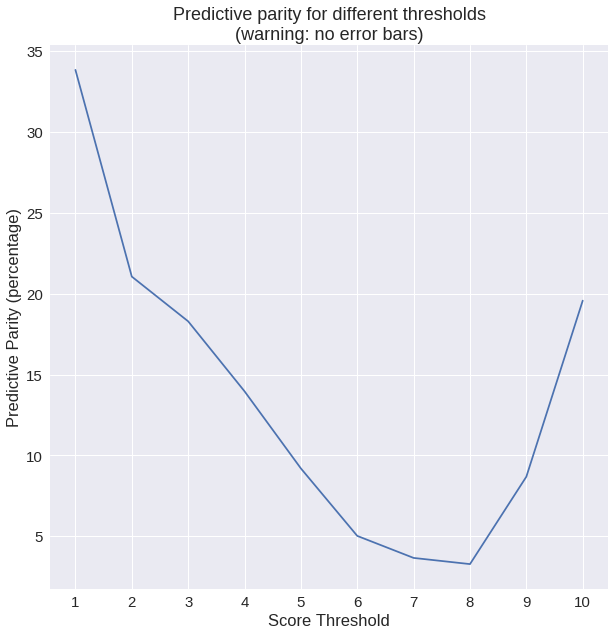

In [19]:
# aux function for thresh score
def threshScore(x,s):
    if x>=s:
        return 1
    else:
        return 0

ppv_values = []
dfP = dfQ[['race','two_year_recid']].copy()
for s in range(1,11):
    dfP['threshScore'] = dfQ['decile_score'].apply(lambda x: threshScore(x,s))
    dfAverage = dfP.groupby(['race','threshScore'])['two_year_recid'].mean().unstack()
    num = dfAverage.loc['African-American',1]
    denom = dfAverage.loc['Caucasian',1]
    ppv_values.append(100*(num/denom-1))


plt.figure(figsize=[10,10])
plt.plot(range(1,11),ppv_values)
plt.xticks(range(1,11))
plt.xlabel('Score Threshold')
plt.ylabel('Predictive Parity (percentage)')
plt.title('Predictive parity for different thresholds\n(warning: no error bars)')

Note how predictive parity depends significantly on the threshold.

We analyze next the difference in *error rates* between groups. First, we look at is the ROC for each group. We normalize the score between 0 and 1. The ROC thresholds produced by `scikitlearn` are the same.

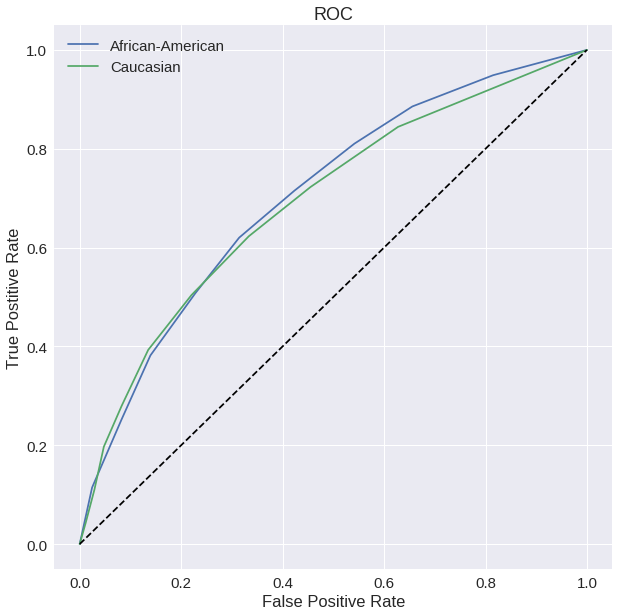

In [20]:
# normalize decile score
max_score = dfQ['decile_score'].max()
min_score = dfQ['decile_score'].min()
dfQ['norm_score'] = (dfQ['decile_score']-min_score)/(max_score-min_score)


plt.figure(figsize=[10,10])
#plot ROC curve for African-Americans
y = dfQ.loc[dfQ['race']=='African-American',['two_year_recid','norm_score']].values
fpr1,tpr1,thresh1 = roc_curve(y_true = y[:,0],y_score=y[:,1])
plt.plot(fpr1,tpr1)

#plot ROC curve for Caucasian
y = dfQ.loc[dfQ['race']=='Caucasian',['two_year_recid','norm_score']].values
fpr2,tpr2,thresh2 = roc_curve(y_true = y[:,0],y_score=y[:,1])
plt.plot(fpr2,tpr2)
l = np.linspace(0,1,10)
plt.plot(l,l,'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Postitive Rate')
plt.title('ROC')
plt.legend(['African-American','Caucasian'])


For each group, the point in the ROC curve corresponds to a $$(\mbox{false postive rate, true positive rate})$$ pair for a given threshold. In order to caputre the difference in error rates, we map the points to $$\left(\frac{\mbox{false postive rate Afr.-American}}{\mbox{false postive rate Cauc.}},s \right)$$
and similarly for *false negative* rates for different thersholds s.

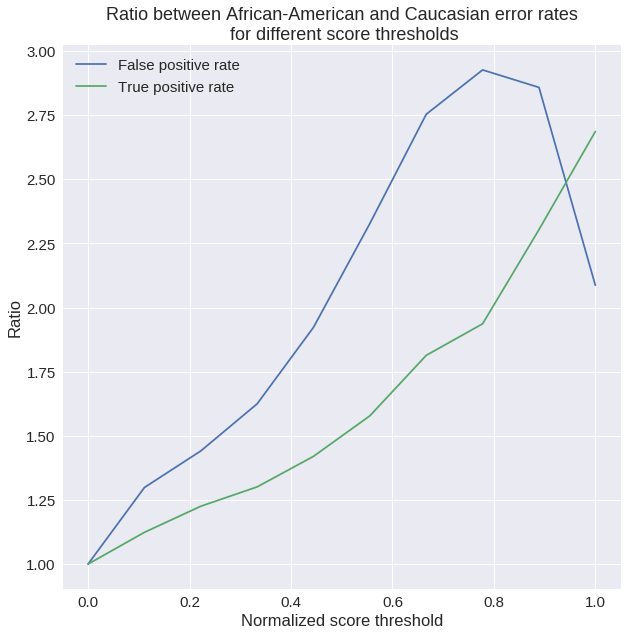

In [21]:
fpr_ratio = fpr1[1:]/fpr2[1:]
tpr_ratio = (tpr1[1:])/(tpr2[1:])
plt.figure(figsize=[10,10])
plt.plot(thresh1[1:],fpr_ratio)
plt.plot(thresh1[1:],tpr_ratio)
plt.xlabel('Normalized score threshold')
plt.ylabel('Ratio')

plt.legend(['False positive rate','True positive rate'])
plt.title('Ratio between African-American and Caucasian error rates\n for different score thresholds')

The difference is once again stark. This graph is particlarly concerning due to the significantly higher false positive rates for African Americans across all thresholds.